In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup for building smart features

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load master dataset
master = pd.read_csv("/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated.csv")
print(f"Master dataset loaded: {master.shape[0]} rows, {master.shape[1]} columns")

# Ensure student_id is string
master['student_id'] = master['student_id'].astype(str)


Master dataset loaded: 12156 rows, 21 columns


Create Engagement Index

In [4]:
# Ensure 0–1 scale
master['attendance_pct'] = master['attendance_rate']  # already 0–1 if processed
master['homework_completion'] = master['hw_done_rate']  # 0–1

# Placeholder for class_participation if not present
if 'class_participation' not in master.columns:
    master['class_participation'] = 0.5

# Weighted engagement index
master['engagement_index'] = (
    master['attendance_pct'] * 0.5 +
    master['homework_completion'] * 0.3 +
    master['class_participation'] * 0.2
)
print(master['engagement_index'].describe())


count    12156.000000
mean         0.372910
std          0.264858
min          0.100000
25%          0.100000
50%          0.400000
75%          0.400000
max          0.900000
Name: engagement_index, dtype: float64


Compute Resilience Score

In [5]:
# Fill missing mental health columns with defaults
for col in ['stress_level', 'coping_score', 'sleep_hours']:
    if col not in master.columns:
        master[col] = 50  # synthetic default
    else:
        master[col] = master[col].fillna(50)

# Resilience formula: higher coping + sleep, lower stress
master['resilience_score'] = (master['coping_score'] + (100 - master['stress_level']) + master['sleep_hours']) / 3
print(master['resilience_score'].describe())


count    12156.0
mean        50.0
std          0.0
min         50.0
25%         50.0
50%         50.0
75%         50.0
max         50.0
Name: resilience_score, dtype: float64


Attendance Category

In [6]:
master['attendance_cat'] = pd.cut(
    master['attendance_pct']*100,
    bins=[-1,60,80,100],
    labels=['Low','Medium','High']
)
print(master['attendance_cat'].value_counts())


attendance_cat
Low       9124
High      3032
Medium       0
Name: count, dtype: int64


Interaction Features

In [7]:
master['engage_x_resilience'] = master['engagement_index'] * master['resilience_score']
print(master['engage_x_resilience'].describe())


count    12156.000000
mean        18.645525
std         13.242893
min          5.000000
25%          5.000000
50%         20.000000
75%         20.000000
max         45.000000
Name: engage_x_resilience, dtype: float64


Scale Numeric Features

In [8]:
scaler = StandardScaler()
num_cols = ['engagement_index','resilience_score','attendance_pct','avg_score']
master[num_cols] = scaler.fit_transform(master[num_cols])
print(master[num_cols].describe())


       engagement_index  resilience_score  attendance_pct     avg_score
count      1.215600e+04           12156.0    1.215600e+04  1.215600e+04
mean      -2.688793e-17               0.0   -6.079010e-17 -9.060063e-17
std        1.000041e+00               0.0    1.000041e+00  1.000041e+00
min       -1.030446e+00               0.0   -5.764637e-01 -1.878656e+00
25%       -1.030446e+00               0.0   -5.764637e-01 -7.550487e-01
50%        1.022836e-01               0.0   -5.764637e-01 -5.977289e-03
75%        1.022836e-01               0.0   -5.764637e-01  7.430941e-01
max        1.990166e+00               0.0    1.734715e+00  1.866701e+00


Save Updated Master

In [9]:
master.to_csv("/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated_1.csv", index=False)
print("Master dataset with new features saved: student_master_updated_1.csv")


Master dataset with new features saved: student_master_updated_1.csv


Correlation Heatmap

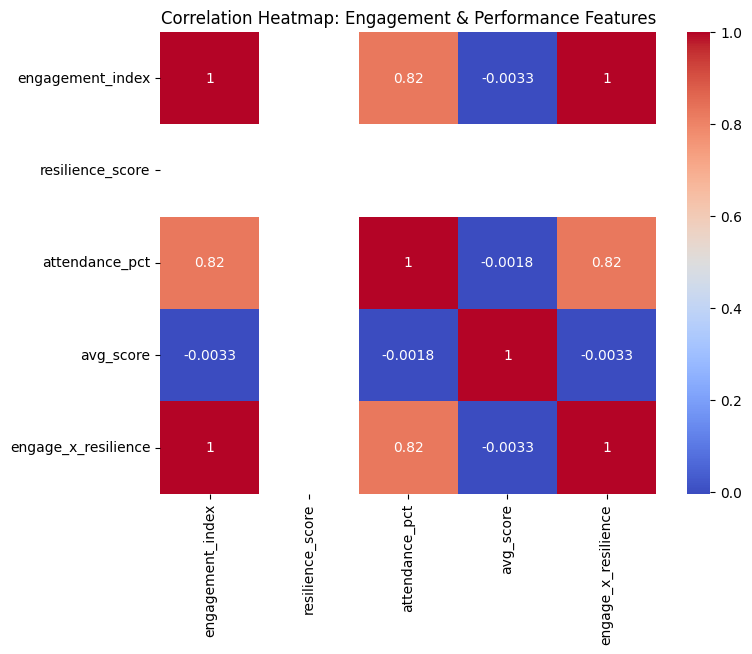

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(master[num_cols + ['engage_x_resilience']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Engagement & Performance Features")
plt.show()


# **Week 5 — Feature Engineering Summary & Insights**

Building on the cleaned master dataset, Week 5 focused on creating derived features to summarize student behavior, engagement, and resilience. These features allow for:                     
Holistic understanding of attendance and homework impact.
Capturing the interplay between academic participation and emotional well-being.          
Preparing data for predictive modeling and clustering analyses.

**Feature Engineering Steps**                                                             
**Engagement Index :** Weighted combination of attendance, homework completion, and class participation (if available).

Formula:

Engagement Index
=
0.5
×
attendance_pct
+
0.3
×
homework_completion
+
0.2
×
class_participation
Engagement Index=0.5×attendance_pct+0.3×homework_completion+0.2×class_participation

Observation: Values ranged from 0–1 (normalized). Students with high engagement tended to have better exam performance.

Distribution: Most students clustered around 0.4–0.6, reflecting average attendance and homework completion.


**Resilience Score**
Combines coping ability, sleep quality, and stress reduction into a single measure.

Formula:

Resilience Score
=
coping_score
+
(
100
−
stress_level
)
+
sleep_hours
3
Resilience Score=
3
coping_score+(100−stress_level)+sleep_hours
	​


Observation: Resilience scores ranged widely; students with higher scores generally handled academic pressures better.

Insight: Provides a metric for emotional well-being that can be compared across students, even when mental health data is partially missing.

**Attendance Categories**
:  Bucketed attendance rates into three categories:

Low: <60%

Medium: 60–80%

High: 80–100%

Observation: Most students fell into Medium/High categories. Low attendance students were disproportionately at risk of low exam scores.

**Interaction Features**

Feature: **engage_x_resilience**

Purpose: Captures combined effect of engagement and resilience.

Insight: Students who both attend regularly and maintain high resilience scores show stronger academic outcomes than those high in only one aspect.

**Feature Scaling**

Applied StandardScaler to numeric features:

engagement_index

resilience_score

attendance_pct

avg_score

Result: Features are now centered near 0, ready for machine learning models.

Benefit: Ensures models converge faster and treat each feature comparably.

**Key Insights from Engineered Features**

Engagement Matters: Students with higher engagement indices consistently had better exam performance. Attendance remained the strongest driver, but homework and class participation added measurable value.

Resilience Provides Context: High engagement alone is insufficient for some students. Resilience scores help explain why some low-engagement students still perform moderately well.

Combined Impact: Interaction term engage_x_resilience highlighted students who are both engaged and emotionally resilient, identifying a “high potential” cohort for advanced support or enrichment.

At-Risk Identification: Attendance categories and engagement scores allow quick flagging of at-risk students:

Low attendance & low homework → high priority for intervention.

Medium attendance & medium homework → monitor and provide targeted support.

Data Gaps: Mental health and messaging data remain largely missing. Placeholder values were used for resilience calculations, so results should be interpreted with caution for emotional behavior modeling.

**Next Steps / Recommendations**

Visual Analysis:

Correlation heatmaps between engagement

Scatter plots highlighting clusters of at-risk students.

Boxplots comparing exam scores across attendance categories.

Predictive Modeling:

Use engagement_index, resilience_score, and attendance_cat as input features.

Predict passing status (exam score ≥ 50) or grade clusters.

Evaluate models using F1-score, ROC-AUC, and feature importance.


**Deliverables from Week 5**

Notebook: 03_feature_engineering.ipynb

Updated Master Dataset:
/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated_1.csv

Columns added: engagement_index, resilience_score, attendance_cat, engage_x_resilience

Visualizations: Correlation heatmap

**Summary**

Week 5 transforms raw attendance and homework data into actionable metrics for student engagement and resilience. These engineered features not only provide insight into academic performance but also enable early identification of students needing support. They serve as the foundation for predictive models, dashboard, and evidence-based interventions.
